In [36]:
import numpy as np

import seaborn

import time 
import matplotlib.pyplot as plt



###  Set up initial parameters for environment 


In [4]:
#  Set up initial parameters for environment 
MAP = ['SFFF', 
       'FHFH', 
       'FFFH', 
       'HFFG']

desc = np.array([[state_desc for state_desc in row] for row in MAP])
nrow, ncol = desc.shape
actions = [ "left", "down", "right","up"]
nA = len(actions) # actions number
nS = nrow * ncol # states number
rs = {
      "H": 0,
      "F": 0,
      "S": 0,
      "G": 1
    }

is_slippery = False
gamma = 0.75

R_positive = 1
r = 0


### Implement helpful functions

In [5]:
def to_s(row, col):
    return row*4 + col


def get_next_state(r, c, action):
    """actions: [0, 1, 2, 3] = [left, down, right, up]"""
    if action == 3:
        r = max(0, r - 1)
    elif action == 1:
        r = min(nrow - 1, r + 1)
    elif action == 0:
        c = max(0, c - 1)
    elif action == 2:
        c = min(ncol - 1, c + 1)
    return r, c


def get_reward(letter, new_letter):
    return rs[new_letter]


In [6]:
def get_dynamics(ncol, nrow, nS, nA):
    P = {s: {a: [] for a in range(nA)} for s in range(nS)}

    for r in range(nrow):
        for c in range(ncol):
            s = to_s(r, c)
            for a in range(nA):
                dynamics = P[s][a]
                letter = desc[r, c]
                if letter in 'HG': # terminal states
                    # (p, s', reward, is_terminal)
                    dynamics.append((0, s, 0, True))
                else:
                    if is_slippery:
                        # define the perpendicular trajectory actions, with the action
                        for b in [(a - 1) % 4, a, (a + 1) % 4]:
                            new_r, new_c = get_next_state(r, c, b)
                            new_s = to_s(new_r, new_c)
                            new_letter = desc[new_r, new_c]
                            terminated = new_letter in'HG'
                            reward = get_reward(letter, new_letter)
                            dynamics.append((1.0/3.0, new_s, reward, terminated)) # there are 2 perpendicular move trajectories, so with the action they add up to 3 probable actions
                    else:
                        new_r, new_c = get_next_state(r, c, a)
                        new_s = to_s(new_r, new_c) 
                        new_letter = desc[new_r, new_c]
                        terminated = new_letter in'HG'
                        reward = get_reward(letter, new_letter)
                        dynamics.append((1.0/3.0, new_s, reward, terminated))
    return P


### 2.a Policy iteration for policy `pi_i(s)`

In [7]:
def policy_iteration(policy, P, gamma=0.75, theta=1e-5):
    delta = np.float32("inf")
    nS = len(P.keys())
    V = np.zeros(nS)

    while theta < delta:
        delta = 0
        
        for s in range(nS):
            Vs = 0
            for action, action_p in enumerate(policy[s]):
                for (p, new_s, reward, terminated) in P[s][action]:
                    Vs += action_p * p * (reward + gamma * V[new_s])
            delta = max(delta, np.abs(V[s] - Vs))
            V[s] = Vs
    return V


(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

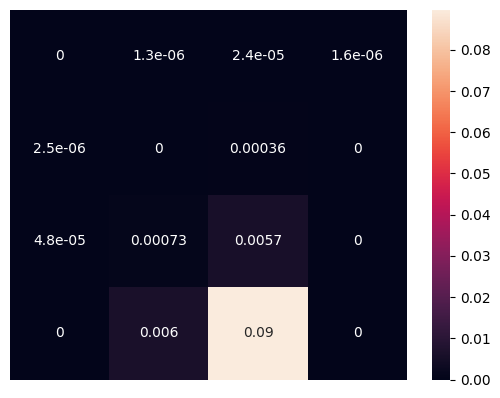

In [8]:
P = get_dynamics(ncol=ncol, nrow=nrow, nS=nS, nA=nA)
policy = np.ones([nS, nA]) / nA
V_pi = policy_iteration(policy, P, gamma=0.75, theta=1e-5)

# visualize
seaborn.heatmap(V_pi.reshape(nrow, ncol), annot=True)
plt.axis("off")


In [ ]:
## Ways for improvement policies:

# State -> improved policy
# Stetes set: (0, ... 15)
# Policy map: 
#              "left": 0, 
#              "down": 1, 
#              "right": 2, 
#              "up": 3

# 0: right
# 1: left
# 3: left
# 4: down
# 5: right
# 6: 

### 2.b Bellman's System of linear equations 

In [5]:
def bellman_SLE(policy, P, gamma=0.75):
    nS = len(P.keys())
    A = np.eye(nS)
    b = np.zeros(nS)
    
    for s in range(nS):
        for action, action_p in enumerate(policy[s]):
            for (p, new_s, reward, terminated) in P[s][action]:
                A[s][new_s] -= action_p * p * gamma
                b[s] += action_p * p * reward

    V = np.linalg.solve(A, b)
    return V, A, b

(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

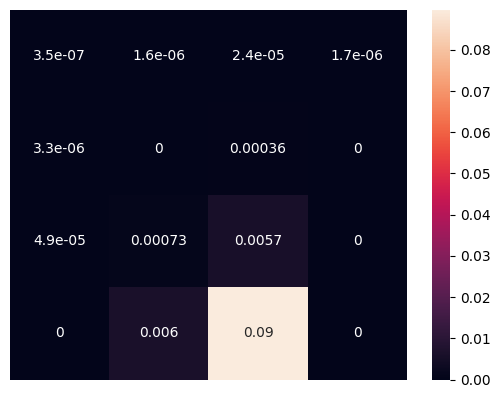

In [58]:
V_bellman, A, b = bellman_SLE(np.ones([nS, nA]) / nA, P)
seaborn.heatmap(V_bellman.reshape(nrow, ncol), annot=True)
plt.axis("off")

### 3 Evaluate Q(s, a) based on V(s) 

In [9]:
def q_from_v(P, V, s, gamma=0.75):
    nA = 4
    q = np.zeros(nA)
    for a in range(nA):
        for (p, new_s, reward, terminated) in P[s][a]:
            q[a] += p * (reward + gamma * V[new_s])
    return q


In [10]:
def Q_from_v(P, V, gamma=0.75):
    nS = V.shape[0] 
    Q = np.array([q_from_v(P, V, s, gamma=gamma) for s in range(nS)])
    return Q


3.a Q(S, a) based on V(S), found with Iterative Policy method

In [11]:
Q_pi = Q_from_v(P, V_pi, gamma=0.75)
np.round(Q_pi, 4)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.400e-03, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e-04, 0.000e+00],
       [0.000e+00, 1.500e-03, 1.400e-03, 0.000e+00],
       [2.000e-04, 2.240e-02, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.500e-03, 2.240e-02, 2.000e-04],
       [1.500e-03, 2.240e-02, 3.333e-01, 1.400e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

3.b Q(S, a) based on V(S), found with Bellman's SLE

In [67]:
Q_bellman = Q_from_v(P, V_bellman, gamma=0.75)
np.round(Q_bellman, 4)

array([[0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.000e-04, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.400e-03, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 2.000e-04, 0.000e+00],
       [0.000e+00, 1.500e-03, 1.400e-03, 0.000e+00],
       [2.000e-04, 2.240e-02, 0.000e+00, 1.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.500e-03, 2.240e-02, 2.000e-04],
       [1.500e-03, 2.240e-02, 3.333e-01, 1.400e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

### 4. Equiprobable function to get random action

In [12]:
def equiprobable(nA):
    return np.random.randint(0, nA)

### Set up FrozenLake environment 

In [13]:
import gymnasium as gym
from time import time

In [14]:
env = gym.make("FrozenLake-v1", 
               is_slippery=is_slippery, 
               desc=MAP,
                render_mode="human"
                )

env.reset()
env.render()

### 5. Implement Get_episode()

In [15]:
def get_optimal_action(policies):
    """Get randomly action from confined array of optimal policies for the state"""
    return np.random.choice(policies)


In [16]:
def get_episode(env, policies=None):
    curr_state, _ = env.reset()

    terminated, truncated = False, False
    episode = []
    while not (terminated or truncated):
        if policies is None:
            action = equiprobable(nA=env.action_space.n)
        else:
            action = get_optimal_action(policies=policies[curr_state])
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode.append((curr_state, action, reward, next_state, terminated, truncated))
        curr_state = next_state
    
    return episode


In [85]:
episode = get_episode(env)
episode

[(0, 1, 0.0, 4, False, False),
 (4, 3, 0.0, 0, False, False),
 (0, 2, 0.0, 1, False, False),
 (1, 3, 0.0, 1, False, False),
 (1, 3, 0.0, 1, False, False),
 (1, 0, 0.0, 0, False, False),
 (0, 1, 0.0, 4, False, False),
 (4, 2, 0.0, 5, True, False)]

### 6. Plot graphs of time and rewards for episode

In [40]:
def plot_episodes(episodes_n, exec_time_arr, rewards):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(range(1, episodes_n + 1), exec_time_arr)
    ax1.set_title("Час виконання get_episode()") # враховуючи час очікування потоку
    ax1.set_xlabel("Епізоди")
    ax1.set_ylabel("Час (секунди)")

    ax2.plot(range(1, episodes_n + 1), rewards)
    ax2.set_title("Винагороди get_episode()")
    ax2.set_xlabel("Епізоди")
    ax2.set_ylabel("Винагороди")

    plt.tight_layout()
    plt.plot()

In [41]:
exec_time_arr_random_policy = []
rewards_random_policy = []
episodes_n = 100

for _ in range(episodes_n):
    s_time = time.perf_counter()
    episode = get_episode(env)
    total_time = time.perf_counter() - s_time
    
    rewards_random_policy.append(sum([step[2] for step in episode]))
    exec_time_arr_random_policy.append(total_time)


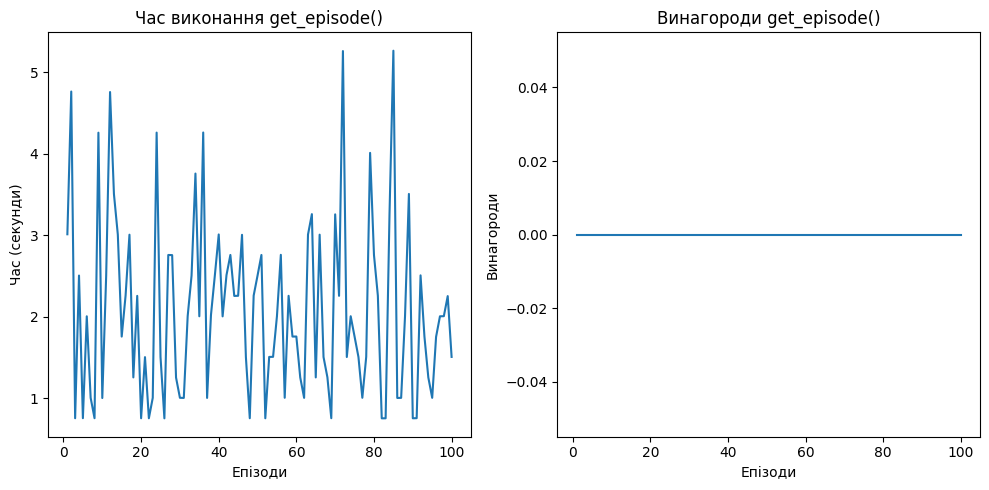

In [42]:
plot_episodes(episodes_n, exec_time_arr_random_policy, rewards_random_policy)


### 7. Prepare functions for optimizing strategy with Iterative Policy, using Q(S, a) 

With value iteration, by given initial strategy

In [27]:
def improve_policy(P, V, policy, gamma=0.75):
    nS = V.shape[0]
    nA = 4

    for s in range(nS):
        q = q_from_v(P, V, s, gamma=gamma)
        best_action = np.argwhere(q == np.max(q)).flatten()
        policy[s] = np.sum([np.eye(nA)[i] for i in best_action], axis=0) / len(best_action)
    return policy


In [25]:
def optimize_policy(P, policy, gamma=0.75, theta=1e-4):
    V_curr = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
    policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
    V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)

    i = 1
    while (V_next == V_curr).all():
        V_curr = V_next
        policy = improve_policy(P=P, V=V_curr, policy=policy, gamma=gamma)
        V_next = policy_iteration(policy=policy, P=P, gamma=gamma, theta=theta)
        i += 1
    
    print(f"Number of steps to reach optimal policy: {i}")
    return V_next, policy


### 8. Optimize policy and get V(S)

Number of steps to reach optimal policy: 1


(np.float64(0.0), np.float64(4.0), np.float64(4.0), np.float64(0.0))

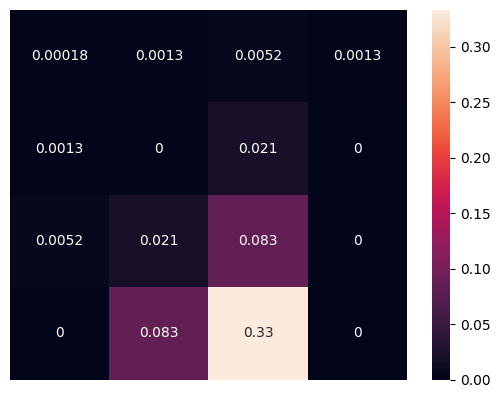

In [28]:
P = get_dynamics(ncol=ncol, nrow=nrow, nS=nS, nA=nA)
policies = np.ones([nS, nA]) / nA # initial strategy
V, policies = optimize_policy(P=P, policy=policies)

seaborn.heatmap(V.reshape(nrow, ncol), annot=True)
plt.axis("off")


### 9. Perform 15 traversals over environment with optimal policy `pi_star``  

In [ ]:
import time

In [43]:
exec_time_arr_greedy_policy = []
rewards_greedy_policy = []
pi_star = [np.argwhere(policies[s] == max_prob).flatten() # map appropriate actions to its probabilities
                       for s, max_prob in  
                       enumerate(np.max(policies, axis=1)) # get maximum action probabilities for each state
]
episodes_n = 15

for _ in range(episodes_n):
    s_time = time.perf_counter()
    episode = get_episode(env, policies=pi_star)
    total_time = time.perf_counter() - s_time
    
    rewards_greedy_policy.append(sum([step[2] for step in episode]))
    exec_time_arr_greedy_policy.append(total_time)
    

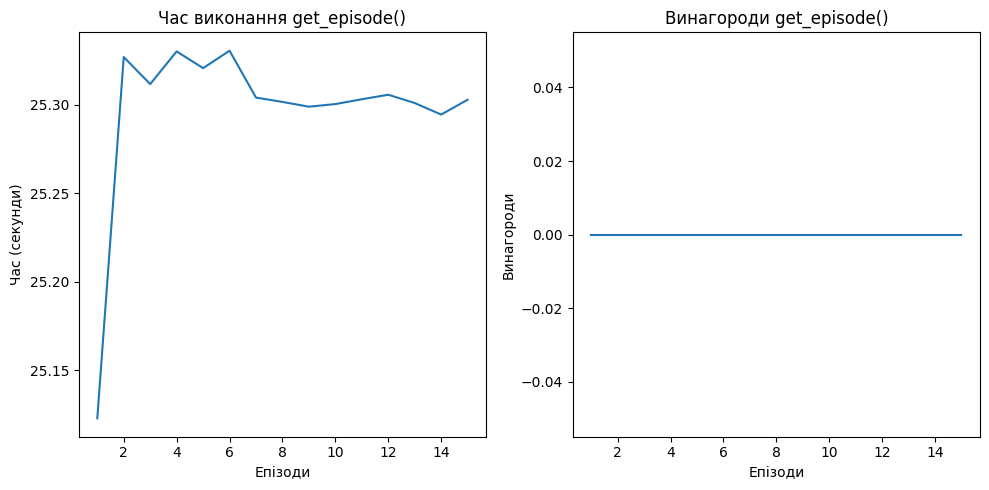

In [44]:
plot_episodes(episodes_n, exec_time_arr_greedy_policy, rewards_greedy_policy)


### 10. Get Q*(S, a) from V*(S) 

In [29]:
# "left": 0, 
# "down": 1, 
# "right": 2, 
# "up": 3

Q_star = Q_from_v(P, V)
np.round(Q_star, 4)

array([[0.000e+00, 3.000e-04, 3.000e-04, 0.000e+00],
       [0.000e+00, 0.000e+00, 1.300e-03, 3.000e-04],
       [3.000e-04, 5.200e-03, 3.000e-04, 1.300e-03],
       [1.300e-03, 0.000e+00, 3.000e-04, 3.000e-04],
       [3.000e-04, 1.300e-03, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 2.080e-02, 0.000e+00, 1.300e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.300e-03, 0.000e+00, 5.200e-03, 3.000e-04],
       [1.300e-03, 2.080e-02, 2.080e-02, 0.000e+00],
       [5.200e-03, 8.330e-02, 0.000e+00, 5.200e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 2.080e-02, 8.330e-02, 5.200e-03],
       [2.080e-02, 8.330e-02, 3.333e-01, 2.080e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

### 11. Implement eps_greedy_policy()

In [18]:
def eps_greedy_policy(q, epsilon):
    r = np.random.rand()
    if r < epsilon:
        # random action
        return np.random.randint(0, len(q))
    else:
        optimal_a = np.max(q)
        return np.random.choice(np.where(q == optimal_a)[0])


In [19]:
def get_greedy_policy(Q, state, epsilon):
    q_s = Q[state]
    nA = len(q_s)
    optimal_a = np.argmax(q_s)
    optimal_actions_n = np.sum(q_s == q_s[optimal_a]) # when number(a*) > 1 
    policy = [1/(optimal_actions_n) - epsilon + epsilon/nA if a == optimal_a 
              else epsilon/nA 
              for a in range(nA)] 
    policy = np.array(policy)
    return policy
    

### 12. Implement E-SARSA (group 3 task)

In [23]:
def expected_sarsa(env, episodes_n, alpha, gamma, Q, epsilon=None):
    for episode_i in range(1, episodes_n+1):
        total_reward = 0

        if epsilon is None:
            epsilon = 1/episode_i
        
        curr_state, _ = env.reset()
        terminated, truncated = False, False
        action = eps_greedy_policy(Q[curr_state], epsilon) 

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if not (terminated or truncated):
                next_action = eps_greedy_policy(Q[next_state], epsilon)
                action_prob_next_s = get_greedy_policy(Q, next_state, epsilon=epsilon)
                Q[curr_state][action] = Q[curr_state][action] + alpha*(reward + gamma*np.dot(action_prob_next_s, Q[next_state]) - Q[curr_state][action])
                
                curr_state = next_state
                action = next_action
            else:
                Q[curr_state][action] = Q[curr_state][action] + alpha*(reward + gamma*0 - Q[curr_state][action])
                break
    
    return Q


### 12. Implement SARSA (group 1 task)

In [19]:
def sarsa(env, episodes_n, alpha, gamma, Q, epsilon):
    for episode_i in range(1, episodes_n+1):
        total_reward = 0
        
        curr_state, _ = env.reset()
        terminated, truncated = False, False
        action = eps_greedy_policy(Q[curr_state], epsilon) 

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            if not (terminated or truncated):
                next_action = eps_greedy_policy(Q[next_state], epsilon)
                Q[curr_state][action] = Q[curr_state][action] + alpha*(reward + gamma*Q[next_state][next_action] - Q[curr_state][action])
                
                curr_state = next_state
                action = next_action
            else:
                Q[curr_state][action] = Q[curr_state][action] + alpha*(reward + gamma*0 - Q[curr_state][action])
                break
    
    return Q


In [20]:
# set initial Q from the policy_1 (task 3)
Q_initial = Q_pi
episodes_n = 500

### 13. Evaluate Q*(S, A) with E-SARSA

13.a epsilon is constant

In [21]:
epsilon = 0.2

Q_1 = sarsa(env, episodes_n=episodes_n, alpha=0.1, gamma=0.75, Q=Q_initial, epsilon=epsilon)
np.round(Q_1, 4)

array([[9.080e-02, 1.316e-01, 2.430e-02, 8.180e-02],
       [0.000e+00, 0.000e+00, 8.410e-02, 0.000e+00],
       [1.000e-04, 2.057e-01, 0.000e+00, 9.500e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.010e-01, 1.572e-01, 0.000e+00, 6.830e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.578e-01, 0.000e+00, 5.400e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.309e-01, 0.000e+00, 2.576e-01, 1.078e-01],
       [1.404e-01, 3.745e-01, 3.301e-01, 0.000e+00],
       [9.140e-02, 6.846e-01, 0.000e+00, 9.160e-02],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 3.695e-01, 6.505e-01, 2.222e-01],
       [4.323e-01, 5.942e-01, 1.000e+00, 3.789e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [22]:
epsilon = 0.8

Q_2 = sarsa(env, episodes_n=episodes_n, alpha=0.1, gamma=0.75, Q=Q_initial, epsilon=epsilon)
np.round(Q_2, 4)

array([[0.0085, 0.0125, 0.0119, 0.0088],
       [0.0092, 0.    , 0.0311, 0.007 ],
       [0.017 , 0.0383, 0.0137, 0.0328],
       [0.0337, 0.    , 0.0073, 0.0067],
       [0.0161, 0.0368, 0.    , 0.0085],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.2052, 0.    , 0.0294],
       [0.    , 0.    , 0.    , 0.    ],
       [0.0443, 0.    , 0.0985, 0.0156],
       [0.048 , 0.1951, 0.1733, 0.    ],
       [0.0863, 0.4524, 0.    , 0.0325],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.    , 0.2284, 0.3884, 0.1192],
       [0.2184, 0.4662, 1.    , 0.1629],
       [0.    , 0.    , 0.    , 0.    ]])

13.b epsilon is dependant on episode k (for E-SARSA, group 1 task only)

In [24]:
Q_3 = expected_sarsa(env, episodes_n=episodes_n, alpha=0.1, gamma=0.75, Q=Q_initial, epsilon=None)
np.round(Q_3, 4)

array([[5.000e-03, 1.140e-02, 2.400e-03, 5.500e-03],
       [6.900e-03, 0.000e+00, 1.000e-03, 3.300e-03],
       [2.700e-03, 4.700e-03, 0.000e+00, 5.000e-04],
       [2.000e-04, 0.000e+00, 0.000e+00, 0.000e+00],
       [1.310e-02, 3.620e-02, 0.000e+00, 6.700e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 5.090e-02, 0.000e+00, 2.000e-04],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [4.660e-02, 0.000e+00, 9.500e-02, 2.340e-02],
       [5.640e-02, 2.301e-01, 1.214e-01, 0.000e+00],
       [5.430e-02, 4.495e-01, 0.000e+00, 3.300e-03],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
       [0.000e+00, 1.616e-01, 4.878e-01, 1.081e-01],
       [1.785e-01, 3.420e-01, 1.000e+00, 1.225e-01],
       [0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]])

In [ ]:
# Compare Q_pi_1(S, A), Q_star_policy_iteration(S, A), 
# and all Q belonging to Q_star_expected_SARSA(S, A)

# Totally 5 graphs

In [31]:
def axis_off(ax):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    

[]

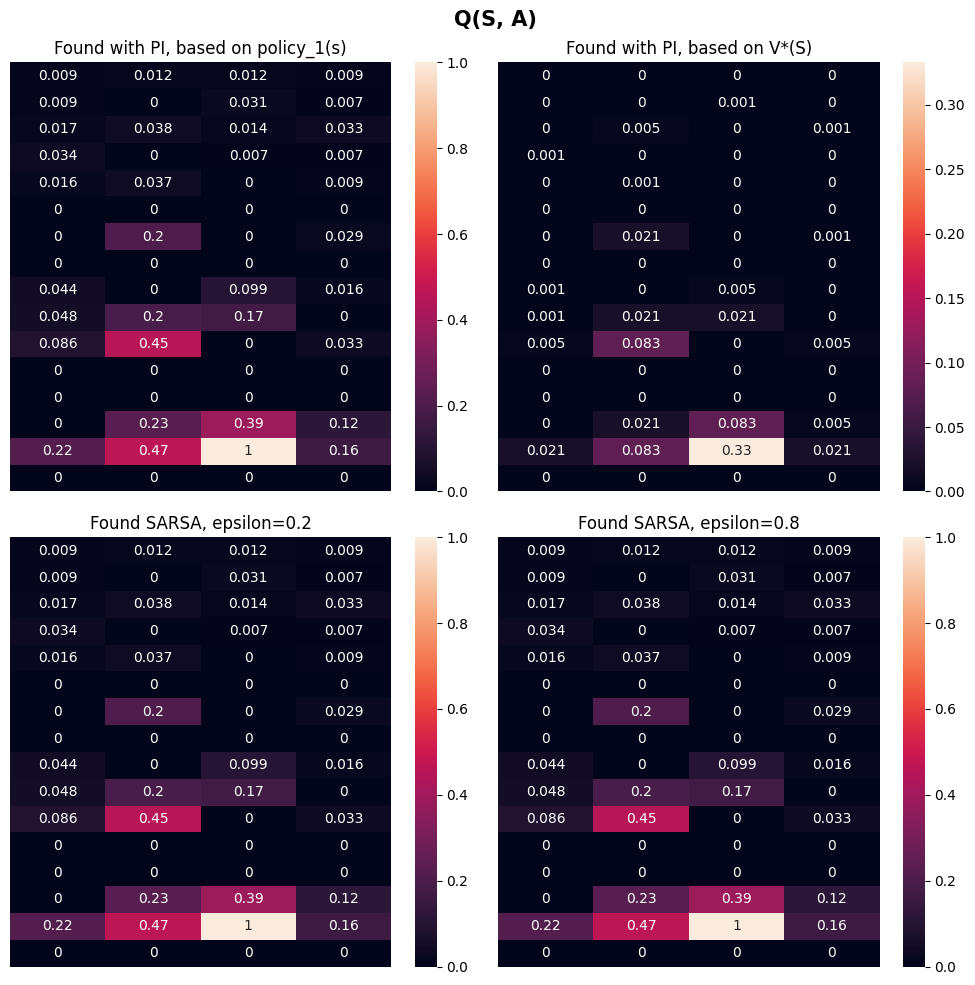

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Q(S, A)", fontsize=15, fontweight="bold")

ax[0, 0].set_title("Found with PI, based on policy_1(s)") # PI - Policy iteration
seaborn.heatmap(np.round(Q_pi, 3), annot=True, ax=ax[0, 0])
axis_off(ax[0, 0])

ax[0, 1].set_title("Found with PI, based on V*(S)") 
seaborn.heatmap(np.round(Q_star, 3), annot=True, ax=ax[0, 1])
axis_off(ax[0, 1])

ax[1, 0].set_title("Found SARSA, epsilon=0.2") 
seaborn.heatmap(np.round(Q_1, 3), annot=True, ax=ax[1, 0])
axis_off(ax[1, 0])

ax[1, 1].set_title("Found SARSA, epsilon=0.8")
seaborn.heatmap(np.round(Q_2, 3), annot=True, ax=ax[1, 1])
axis_off(ax[1, 1])

# ax[1, 2].set_title("Found E-SARSA, epsilon=1/k, k=1...100") 
# seaborn.heatmap(np.round(Q_3, 3), annot=True, ax=ax[1, 2])
# axis_off(ax[1, 2])

plt.tight_layout()
plt.plot()


In [ ]:
# It's necessary more than 500 episodes for Q(S, A) in order to converge to Q*(S, A) found with PI


### 14. Create epsilon-based strategy based on any of Q(S, A), found with E-SARSA 

In [ ]:
# epsilon=0.2 and epsilon=0.8 Q matrices are almost identical, 
# so, we can choose any of them

# We'll pick the one, found with epsilon=0.2. 


In [34]:
epsilon = 0.2
policy_2 = [eps_greedy_policy(q, epsilon) for q in Q_1]
policies = np.array(policy_2).reshape((nS, 1)) # step necessary for get_episode()'s `policies` parameter specificity  
policies

array([[1],
       [2],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [2],
       [1],
       [3],
       [0],
       [1],
       [2],
       [2],
       [1]])

## 15. Traverse over episode with policy_2

In [37]:
import time

In [38]:
exec_time_arr_epsilon_greedy_policy = []
rewards_epsilon_greedy_policy = []
episodes_n = 50
for _ in range(episodes_n):
    s_time = time.perf_counter()
    episode = get_episode(env, policies=policies)
    total_time = time.perf_counter() - s_time
    
    rewards_epsilon_greedy_policy.append(sum([step[2] for step in episode]))
    exec_time_arr_epsilon_greedy_policy.append(total_time)
    

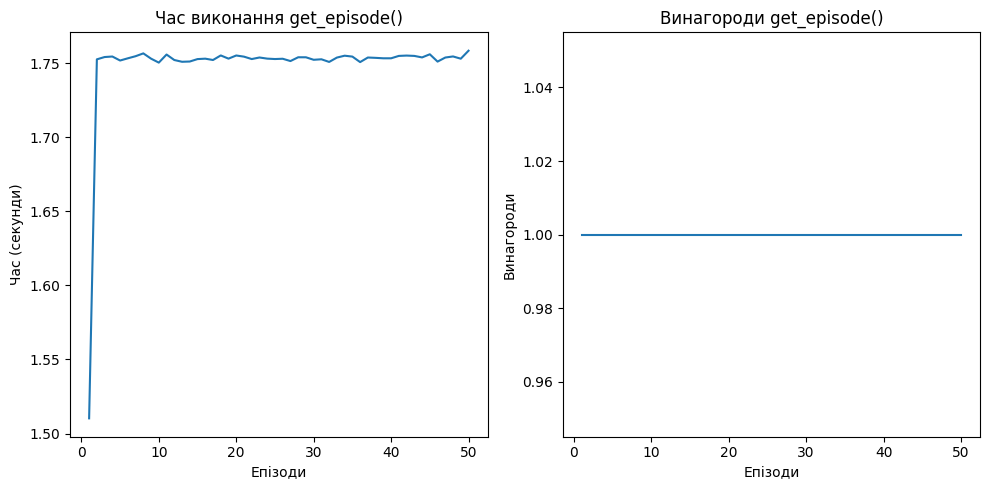

In [47]:
plot_episodes(episodes_n=50, exec_time_arr=exec_time_arr_epsilon_greedy_policy, rewards=rewards_epsilon_greedy_policy)


In [ ]:
# compare episode traversals:
# + wit random strategy pi_1
# + with greedy optimal strategy pi_*
# + with epsilon-greedy optimal strategy   

In [ ]:
exec_time_arr_random_policy
exec_time_arr_greedy_policy
exec_time_arr_epsilon_greedy_policy

rewards_random_policy
rewards_greedy_policy
rewards_epsilon_greedy_policy

In [48]:
plot_data = \
[(exec_time_arr_random_policy, rewards_random_policy),
 (exec_time_arr_greedy_policy, rewards_greedy_policy),
 (exec_time_arr_epsilon_greedy_policy, rewards_epsilon_greedy_policy)]

episodes_ns = [100, 15, 50]

[]

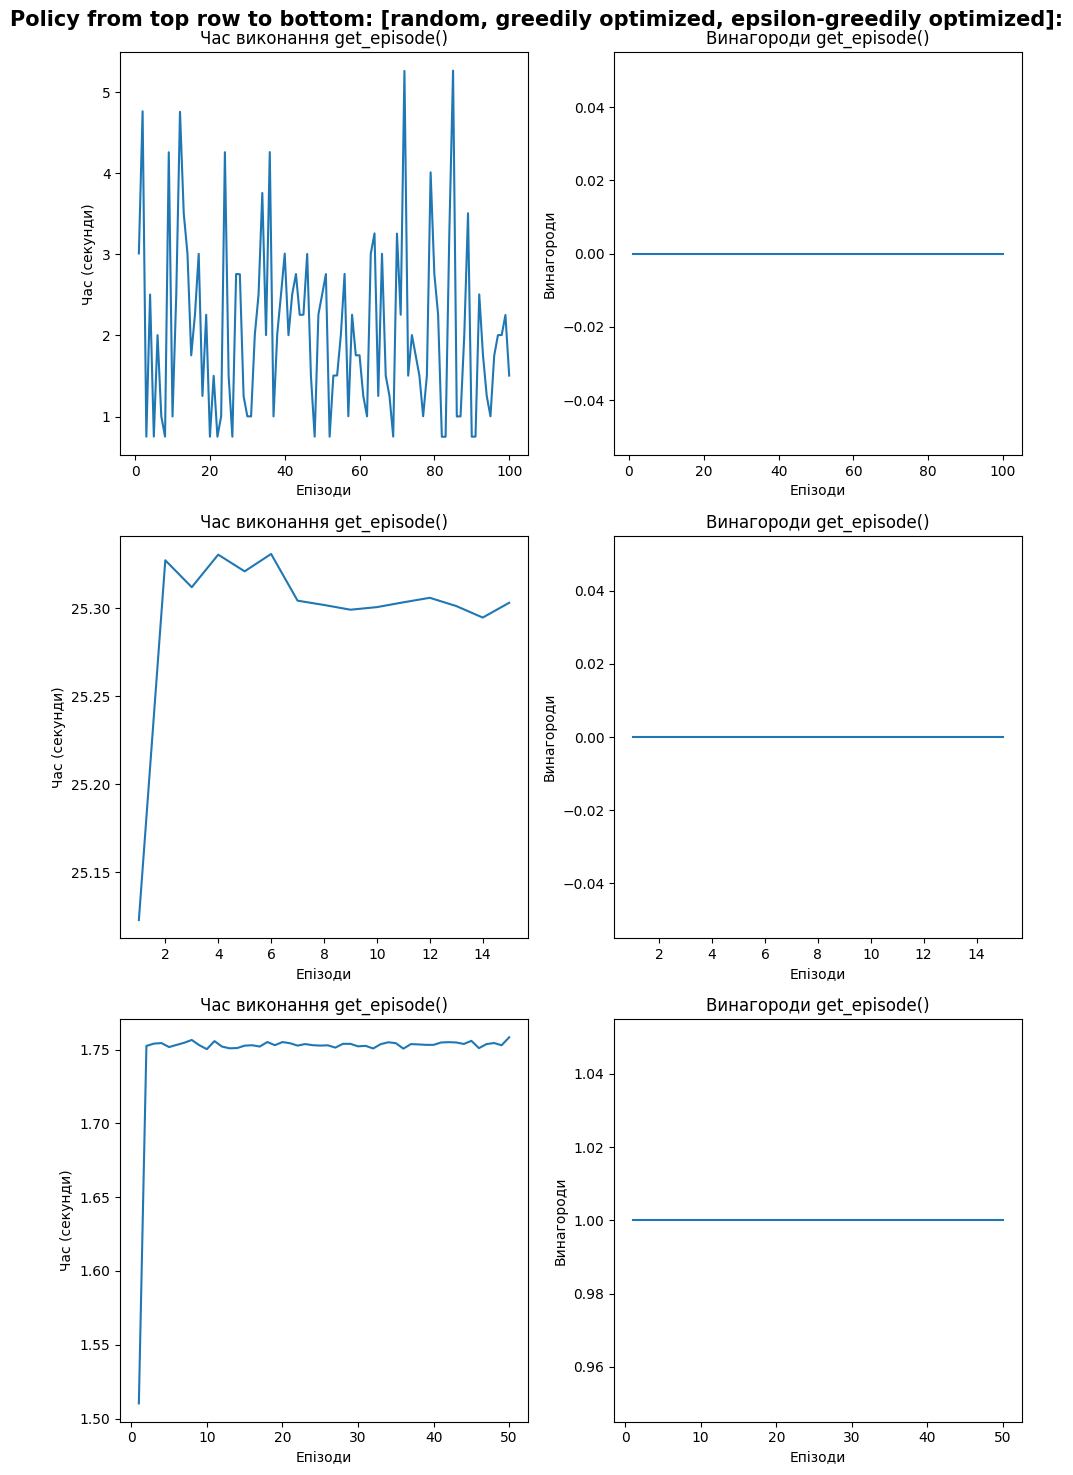

In [49]:

fig, ax = plt.subplots(3, 2, figsize=(10, 15))
for i, (episodes_n, (exec_time, rewards)) in enumerate(zip(episodes_ns, plot_data)):
    ax[i, 0].plot(range(1, episodes_n + 1), exec_time)
    ax[i, 0].set_title("Час виконання get_episode()") # враховуючи час очікування потоку
    ax[i, 0].set_xlabel("Епізоди")
    ax[i, 0].set_ylabel("Час (секунди)")
    ax[i, 1].plot(range(1, episodes_n + 1), rewards)
    ax[i, 1].set_title("Винагороди get_episode()")
    ax[i, 1].set_xlabel("Епізоди")
    ax[i, 1].set_ylabel("Винагороди")

fig.suptitle("Policy from top row to bottom: [random, greedily optimized, epsilon-greedily optimized]:", fontsize=15, fontweight="bold")
plt.tight_layout()
plt.plot()

In [50]:
# shut down environment
env.close()